In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

from utils.schemas import *
from utils.functions import *

In [2]:
df_imp = pd.read_csv('docs/ft_importances_20190811.csv')

In [7]:
df_imp.head(10)

,feature,importance
0,TransactionAmt,3.000000
1,card1,2.204488
2,C13,2.070567
3,N1,1.881225
4,C1,1.691782
5,card2,1.664059
6,addr1,1.501876
7,N3,1.417283
8,D15,1.384750
9,C14,1.305814


In [3]:
X_cols = df_imp[df_imp.importance > 0.1].feature.to_list()

In [4]:
data_folder = 'input'

In [5]:
train = pd.read_csv(data_folder+'/train_ft_eng_0.csv', dtype = schema_generated_0, usecols=X_cols+['isFraud', 'TransactionDT'])
# test = pd.read_csv(data_folder+'/test_ft_eng_0.csv', dtype = schema_generated_0, usecols=X_cols)

In [6]:
train.shape

(590540, 245)

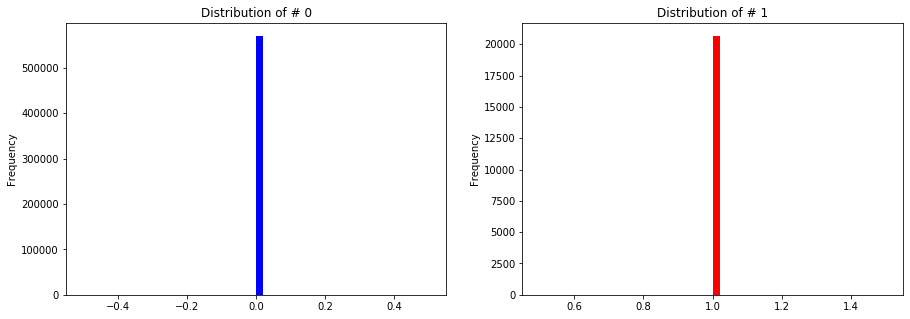

In [9]:
f,ax=plt.subplots(1,2,figsize=(15,5))
train[train.isFraud == 0].isFraud.plot.hist(ax=ax[0], color = 'blue', bins=50)
ax[0].set_title('Distribution of # 0')
train[train.isFraud == 1].isFraud.plot.hist(ax=ax[1], color = 'red', bins=50)
ax[1].set_title('Distribution of # 1')
plt.show()

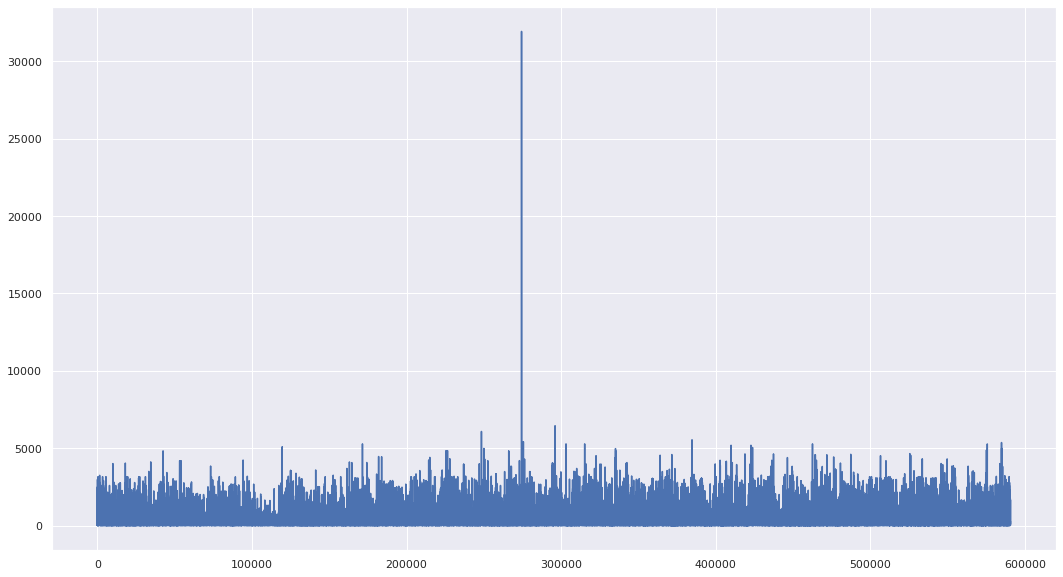

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
ax.plot(list(range(train.TransactionAmt.shape[0])), train.TransactionAmt)
plt.show()

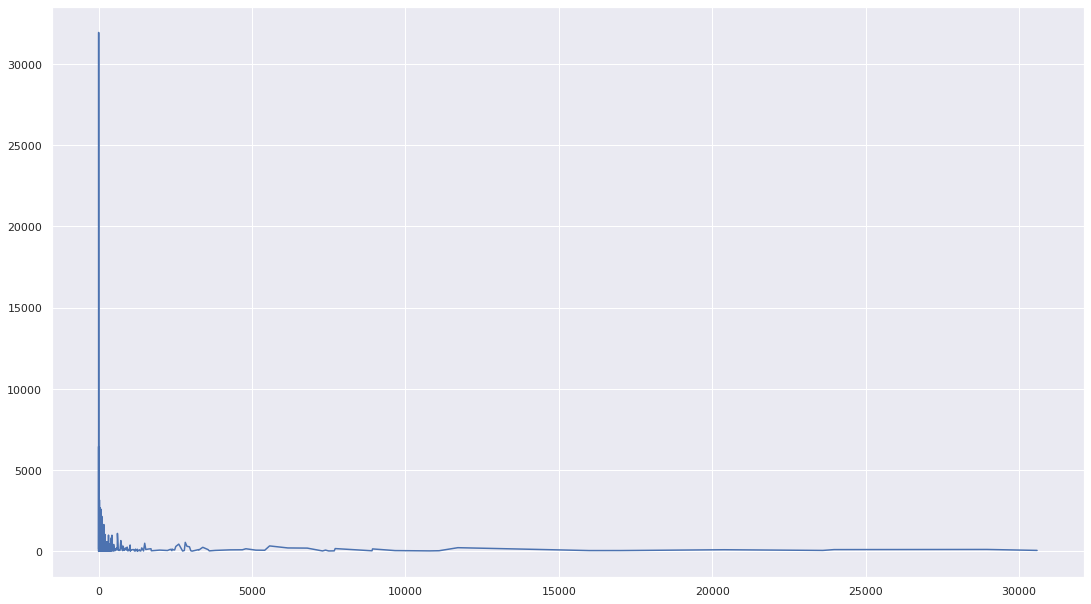

In [32]:
train.TransactionAmt.value_counts()

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train.TransactionAmt.value_counts(), train.TransactionAmt.value_counts().index.to_list())
plt.show()

In [11]:
import seaborn as sns
sns.set()

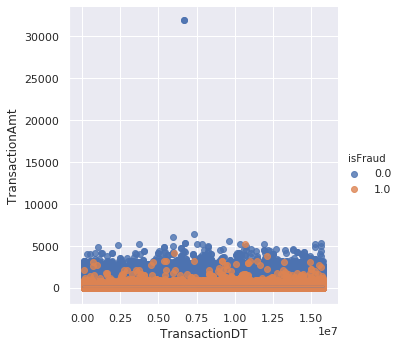

In [34]:
import seaborn as sns
sns.set()

# Ver si utilizando el std o la media en TransactionAmt aumenta el target
g = sns.lmplot(x="TransactionDT", y="TransactionAmt", hue="isFraud",
               truncate=True, height=5, data=train[['TransactionDT', 'TransactionAmt', 'isFraud']])


In [42]:
card_tran = train.groupby(['card1', 'TransactionAmt']).count()

In [45]:
group1 = card_tran['TransactionDT']
group1.name = 'card_count_transaction'
train2 = train.join(group1, on=['card1', 'TransactionAmt'])

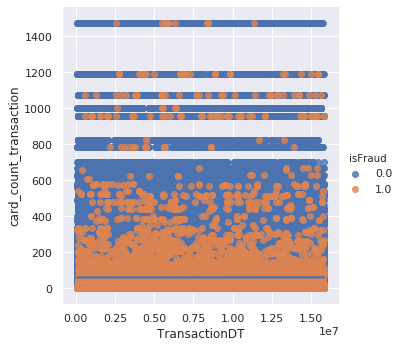

In [47]:
g = sns.lmplot(x="TransactionDT", y="card_count_transaction", hue="isFraud",
               truncate=True, height=5, data=train2[['TransactionDT', 'card_count_transaction', 'isFraud']])

In [9]:
train['trans_dif'] = train['TransactionAmt'] - train['TransactionAmt'].apply(lambda x: int(x))

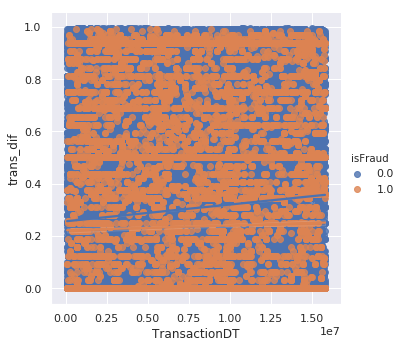

In [13]:
g = sns.lmplot(x="TransactionDT", y="trans_dif", hue="isFraud",
               truncate=True, height=5, data=train)

In [51]:
d = train.std(axis = 0, skipna = True)['TransactionAmt']
m = np.mean(train['TransactionAmt'].values)
train['des_amt'] = train['TransactionAmt'].apply(lambda x: (x-d)/m)

In [52]:
m, d

(135.0, 239.15743790426998)

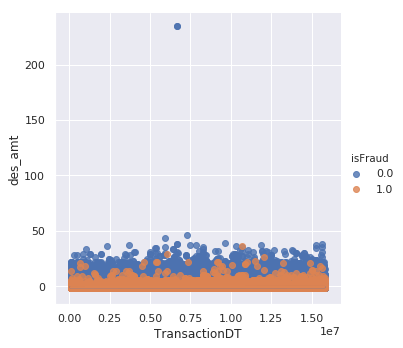

In [53]:
g = sns.lmplot(x="TransactionDT", y="des_amt", hue="isFraud",
               truncate=True, height=5, data=train)

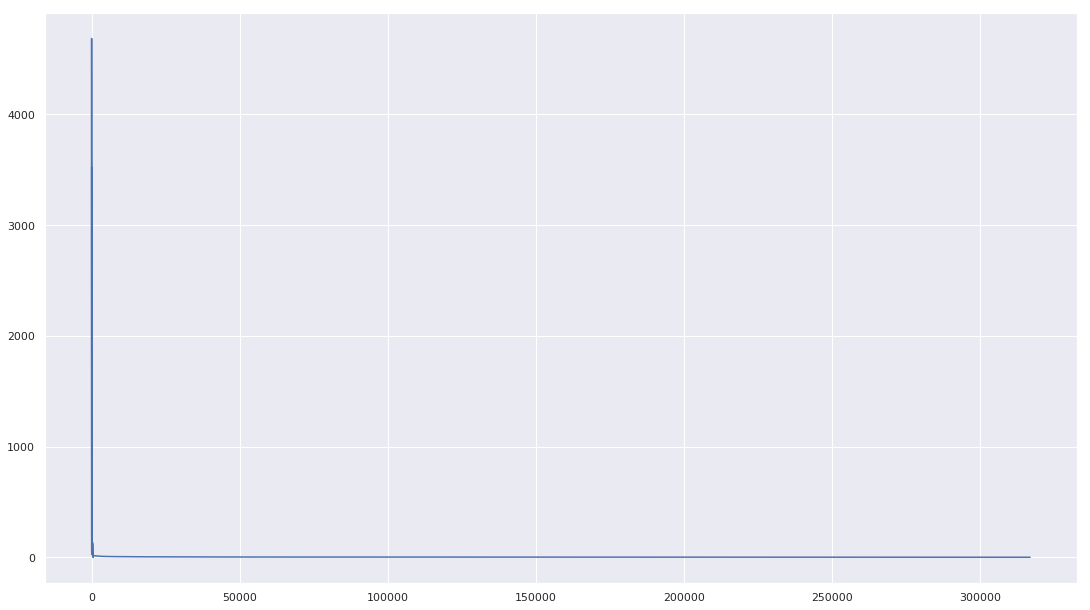

In [55]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train.C1.value_counts(), train.C1.value_counts().index.to_list())
plt.show()

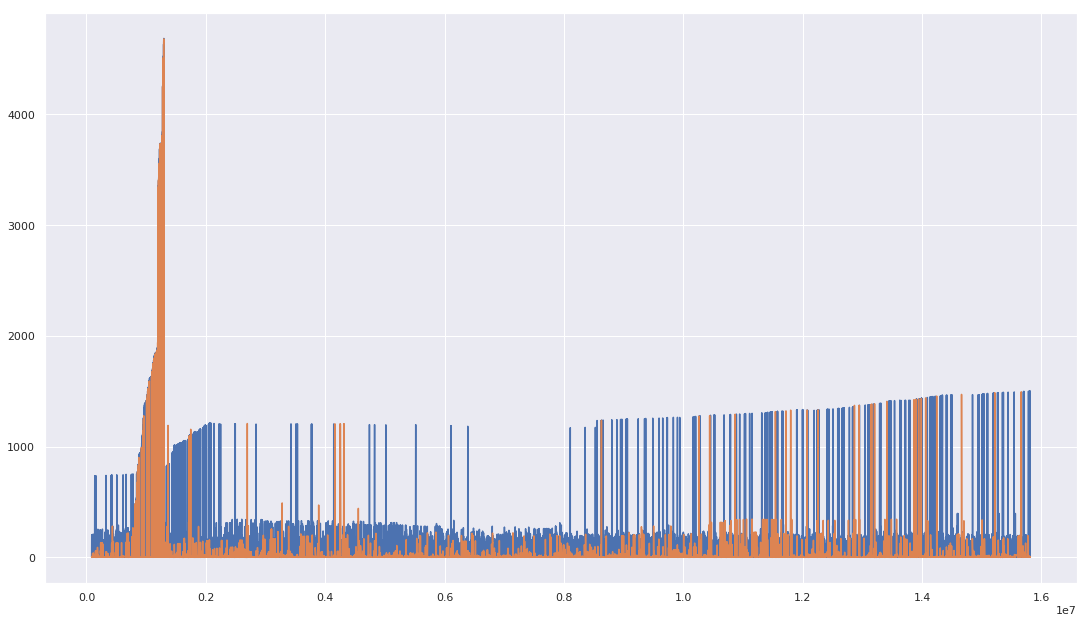

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].C1)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].C1)
plt.show()

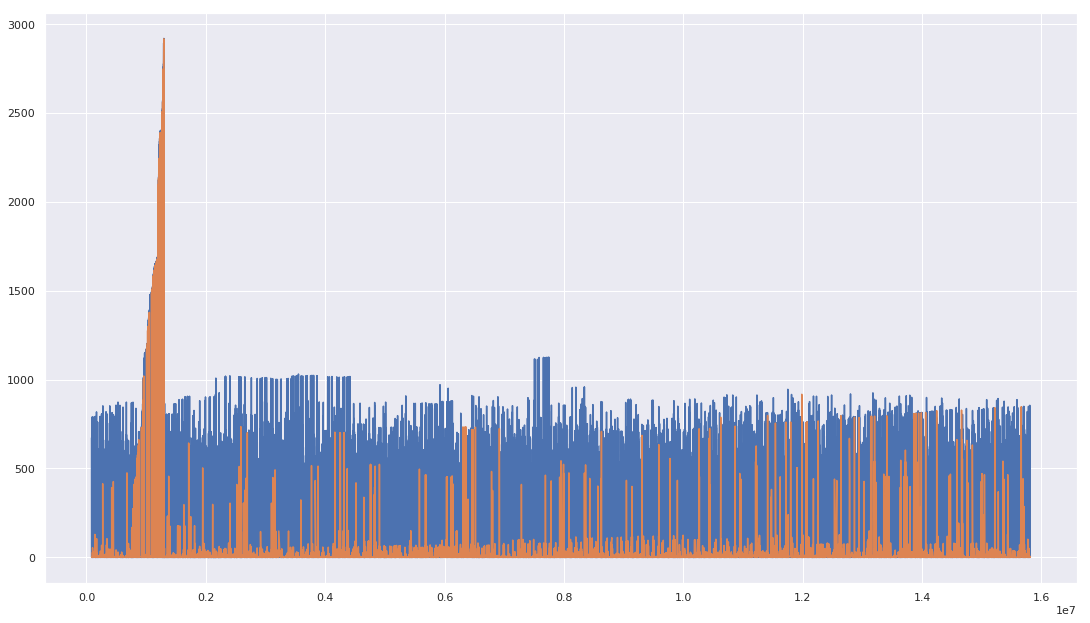

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].C13)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].C13)
plt.show()

In [77]:
train.D15/train.D1

0          0.000000
1               NaN
2               inf
3          0.991211
4               NaN
5               NaN
6               NaN
7               NaN
8               NaN
9          5.214844
10         0.000000
11              NaN
12         1.486328
13         0.978027
14              NaN
15              NaN
16              NaN
17              NaN
18              NaN
19         1.000000
20              NaN
21         0.224731
22              NaN
23              NaN
24         0.984863
25              inf
26              inf
27              NaN
28         0.000000
29              NaN
            ...    
590510          NaN
590511    12.046875
590512          NaN
590513          inf
590514     6.242188
590515    30.859375
590516     1.000000
590517          NaN
590518     1.003906
590519     1.000000
590520    11.804688
590521          NaN
590522     1.000000
590523     1.142578
590524          inf
590525     1.030273
590526          NaN
590527     1.071289
590528          inf


In [70]:
X_cols

['TransactionAmt',
 'card1',
 'C13',
 'N1',
 'C1',
 'card2',
 'addr1',
 'N3',
 'D15',
 'C14',
 'Transaction_hour',
 'C11',
 'card1_fe1',
 'addr1_fe1',
 'N2',
 'D1',
 'card2_fe1',
 'group_2_n_64',
 'C6',
 'dist1',
 'D2',
 'D4',
 'Transaction_day_of_week',
 'addr1_fe2',
 'C2',
 'D10',
 'V258',
 'N4',
 'group_2_n_32',
 'card2_fe2',
 'P_emaildomain',
 'V307',
 'id_02',
 'card5',
 'card1_fe2',
 'DeviceInfo',
 'P_emaildomain_0',
 'V45',
 'V310',
 'C12',
 'P_emaildomain_fe2',
 'D11',
 'M5',
 'D3',
 'V317',
 'M6',
 'C9',
 'D8',
 'V308',
 'V201',
 'group_2_n_16',
 'card6',
 'id_19',
 'P_emaildomain_0_fe1',
 'card5_fe1',
 'V313',
 'id_31',
 'P_emaildomain_0_fe2',
 'V257',
 'C4',
 'D5',
 'C7',
 'V200',
 'V283',
 'M6_fe2',
 'C8',
 'id_20',
 'card5_fe2',
 'P_emaildomain_fe1',
 'C10',
 'V87',
 'V281',
 'V243',
 'V312',
 'V294',
 'V189',
 'V246',
 'M4',
 'M5_fe1',
 'V187',
 'V315',
 'V314',
 'V244',
 'V44',
 'V127',
 'card6_fe1',
 'id_01',
 'id_13',
 'group_1_n_64',
 'V54',
 'V53',
 'V62',
 'R_emaild

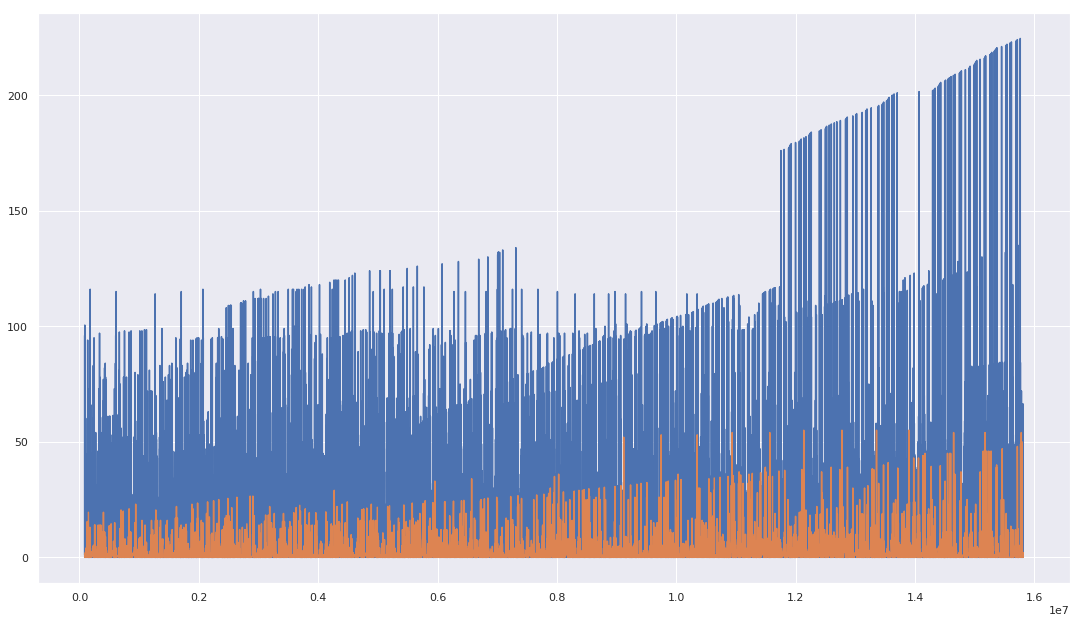

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].C13/
       train[train.isFraud == 0].C1)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].C13/
       train[train.isFraud == 1].C1)
plt.show()

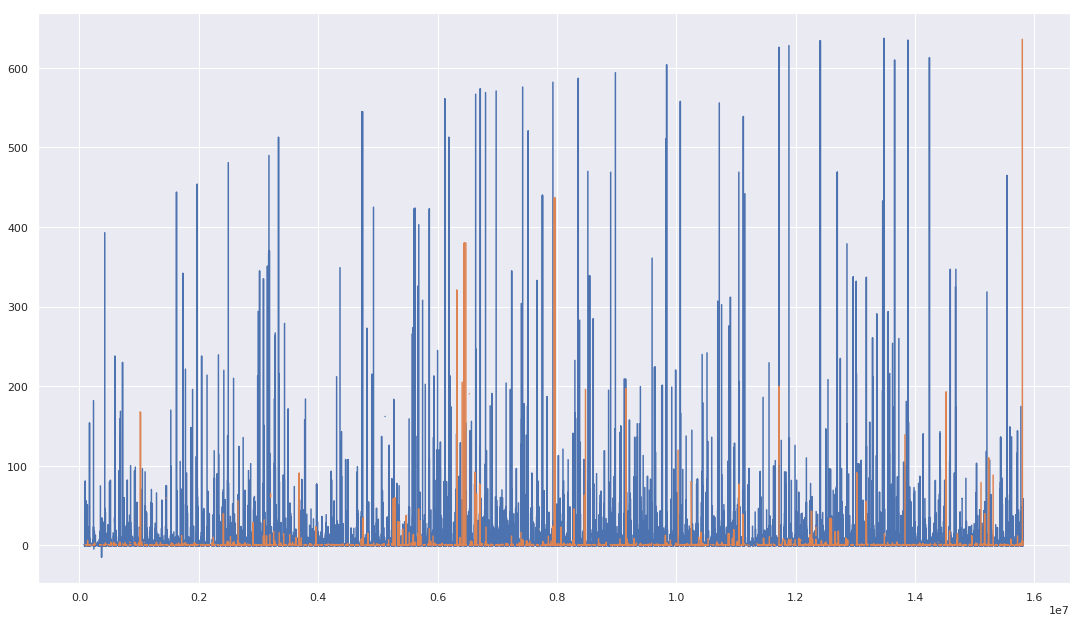

In [79]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(train[train.isFraud == 0].TransactionDT, train[train.isFraud == 0].D1/
       train[train.isFraud == 0].D15)
ax.plot(train[train.isFraud == 1].TransactionDT, train[train.isFraud == 1].D1/
       train[train.isFraud == 1].D15)
plt.show()